In [ ]:
!pip install Groq requests

In [ ]:
import requests
import json
from groq import Groq

def main():
    models = [
        "gemma-7b-it",
        "gemma2-9b-it",
        "llama3-groq-70b-8192-tool-use-preview",
        "llama3-groq-8b-8192-tool-use-preview",
        "mixtral-8x7b-32768",
        "llama-3.1-70b-versatile",
        "llama-3.1-8b-instant",
        "llama-3.2-11b-text-preview",
        "llama-3.2-1b-preview",
        "llama-3.2-3b-preview",
        "llama-3.3-70b-specdec",
        "llama-3.3-70b-versatile",
        "gemini-1.5-flash-latest"
    ]

    print("Available LLMs:")
    for idx, model in enumerate(models, 1):
        print(f"{idx}. {model}")

    # Get user selection
    while True:
        try:
            selection = int(input("Please select the LLM to use (enter the number): "))
            if 1 <= selection <= len(models):
                selected_model = models[selection - 1]
                break
            else:
                print(f"Please enter a number between 1 and {len(models)}.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    # User prompt
    user_prompt = input("Please enter your prompt: ")

    system_prompt = """You are a robot arm action planner working with blocks in the environment.
The environment includes three blocks as the objects: a red block labeled as number one, a green block labeled as number two, and a blue block labeled as number three. The environment also includes four locations: pyramid_base_left (one of the bottom layers of the pyramid), pyramid_base_right (one of the bottom layers of the pyramid), pyramid_top (the topmost layer of the pyramid, placed on top of other blocks), and target_center (a target location with no object initially on it).
You can also consider the location of an object as the location of a target"""

    if selected_model == "gemini-1.5-flash-latest":
        output = generate_content_gemini(system_prompt, user_prompt)
        if output:
            print("\nLLM Output:")
            try:
                for part in output["candidates"][0]["content"]["parts"]:
                    print(part["text"])
            except (KeyError, IndexError) as e:
                print("Error extracting text:", e)
        else:
            print("No output received from the Gemini API.")
    else:
        completion = generate_content_groq(selected_model, system_prompt, user_prompt)
        print("\nLLM Output:")
        print(completion.choices[0].message.content)

def generate_content_groq(selected_model, system_prompt, user_prompt):
    client = Groq(api_key="ENTER_YOUR_API_KEY")

    common_params = {
        "model": selected_model,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "temperature": 1,
        "max_tokens": 1024,
        "top_p": 1,
        "stream": False,
        "stop": None,
    }

    if "llama3-groq" in selected_model:
        common_params["temperature"] = 0.5
        common_params["top_p"] = 0.65

    completion = client.chat.completions.create(**common_params)
    return completion

def generate_content_gemini(system_prompt, user_prompt):
    API_ENDPOINT = "https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent"
    API_KEY = "ENTER_YOUR_API_KEY"

    combined_prompt = f"{system_prompt}\nUser: {user_prompt}"

    payload = {
        "contents": [
            {
                "parts": [
                    {
                        "text": combined_prompt
                    }
                ]
            }
        ]
    }

    headers = {
        "Content-Type": "application/json"
    }

    # Send POST request to the API
    response = requests.post(
        f"{API_ENDPOINT}?key={API_KEY}",
        headers=headers,
        data=json.dumps(payload)
    )

    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        print("Request failed:", response.status_code, response.text)
        return None

if __name__ == "__main__":
    main()

Available LLMs:
1. gemma-7b-it
2. gemma2-9b-it
3. llama3-groq-70b-8192-tool-use-preview
4. llama3-groq-8b-8192-tool-use-preview
5. mixtral-8x7b-32768
6. llama-3.1-70b-versatile
7. llama-3.1-8b-instant
8. llama-3.2-11b-text-preview
9. llama-3.2-1b-preview
10. llama-3.2-3b-preview
11. llama-3.3-70b-specdec
12. llama-3.3-70b-versatile
13. gemini-1.5-flash-latest
Please select the LLM to use (enter the number): 13
Please enter your prompt: You can perform the following actions: go_to(target): Controls the end effector of the robot arm to move to the target object and position itself directly above the target, maintaining a vertical alignment. pick_up(target): Opens the gripper, then controls the end effector of the robot arm to approach the target object vertically from above. Once the end effector reaches the target, it closes the gripper to securely grasp and lift the object. drop_to(target): Assumes the gripper is already picked up an object using the pick_up(target) action. Controls th

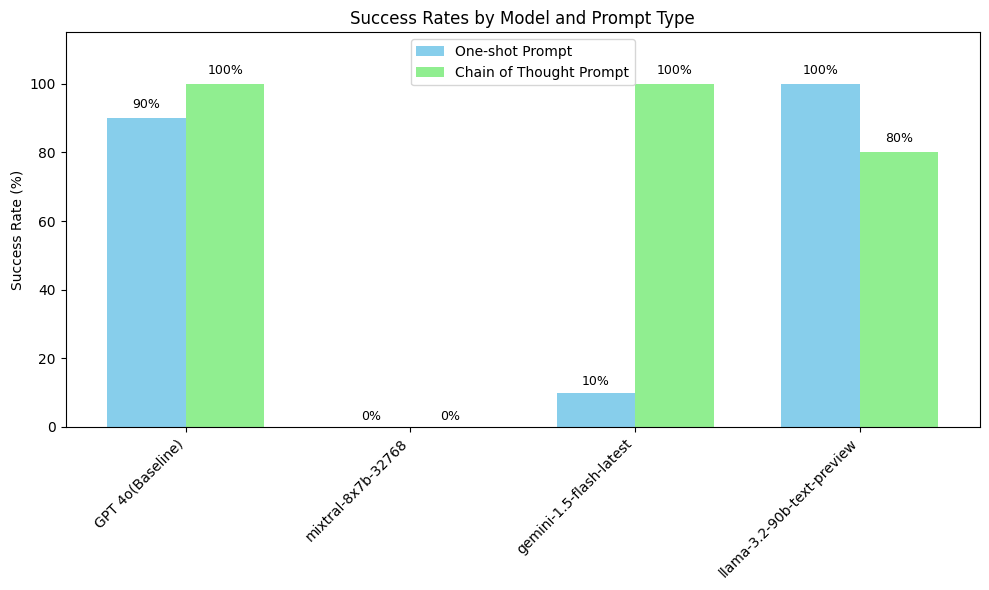

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['GPT 4o(Baseline)', 'mixtral-8x7b-32768', 'gemini-1.5-flash-latest', 'llama-3.2-90b-text-preview']
one_shot = [90, 0, 10, 100]  # Success rates in percentages
chain_of_thought = [100, 0, 100, 80]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, one_shot, width, label='One-shot Prompt', color='skyblue')
rects2 = ax.bar(x + width/2, chain_of_thought, width, label='Chain of Thought Prompt', color='lightgreen')

ax.set_ylabel('Success Rate (%)')
ax.set_title('Success Rates by Model and Prompt Type')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend()

def autolabel(rects):
    """Attach a text label displaying the height."""
    for rect in rects:
        height = rect.get_height()
        if height < 20:
            va = 'bottom'
            offset = 3
        else:
            va = 'bottom'
            offset = 5
        ax.annotate(f'{height}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, offset),
                    textcoords="offset points",
                    ha='center', va=va,
                    fontsize=9,
                    color='black')

autolabel(rects1)
autolabel(rects2)
max_height = max(one_shot + chain_of_thought)
ax.set_ylim(0, max_height + 15)

fig.tight_layout()
plt.show()